L'objectif est de mettre en place une méthodologie générale permettant de calibrer des smiles de vol sur une base de modèle stochastique. La paramètrisation est de type Stochastic Volatility Inspired.

In [184]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def replace_commas(value):
    return float(value.replace(',', '.'))

# Correct the converters dictionary to specify column names individually
converters = {
    "C_IV": replace_commas,
    "P_IV": replace_commas
}

# Read the CSV file with proper column converters
data = pd.read_csv("raw_data.csv", sep=";", converters=converters)

# Access the unique values of 'DTE' column
unique = pd.unique(data['DTE'])
expiry = unique[7]
print(unique)

[2.70000e-01 2.27000e+00 5.27000e+00 7.27000e+00 9.27000e+00 1.22700e+01
 1.42700e+01 1.62700e+01 2.02700e+01 2.12700e+01 2.32700e+01 2.62700e+01
 2.82700e+01 2.92700e+01 3.02700e+01 3.72700e+01 4.42700e+01 5.72700e+01
 7.22300e+01 8.62300e+01 1.06230e+02 1.18230e+02 1.49230e+02 1.70230e+02
 1.77230e+02 2.61230e+02 2.71230e+02 3.52270e+02 3.63270e+02 3.80270e+02
 4.43230e+02 5.34230e+02 7.16270e+02 1.08027e+03]


This ensures the Log(K/S) is used instead of other.

float64


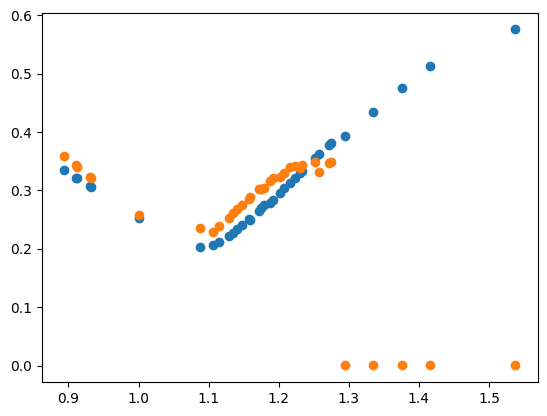

In [185]:
expiry_Iv_raw_data = data[data["DTE"]==expiry]
expiry_Iv_raw_data = expiry_Iv_raw_data.copy()
expiry_Iv_raw_data.loc[:, "SimpleMoneyness"] = expiry_Iv_raw_data["STRIKE"] / expiry_Iv_raw_data["UNDERLYING_LAST"]
expiry_Iv_raw_data["C_IV"] = expiry_Iv_raw_data["C_IV"].astype(float, copy = True)
expiry_Iv_raw_data["P_IV"] = expiry_Iv_raw_data["P_IV"].astype(float)
plt.scatter(expiry_Iv_raw_data["SimpleMoneyness"], expiry_Iv_raw_data["C_IV"], label = "Calls smile")
plt.scatter(expiry_Iv_raw_data["SimpleMoneyness"], expiry_Iv_raw_data["P_IV"], label = "Puts smile")
print(expiry_Iv_raw_data["C_IV"].dtype)


Now let's implement the fitting function and the SVI formula

In [186]:
call_volume = np.array(expiry_Iv_raw_data["C_VOLUME"].copy())
put_volume = np.array(expiry_Iv_raw_data["P_VOLUME"].copy())
iv_call = np.array(expiry_Iv_raw_data["C_IV"].copy())
iv_put = np.array(expiry_Iv_raw_data["P_IV"].copy())
moneyness = expiry_Iv_raw_data["SimpleMoneyness"].copy()

The datas selection

[1.08829336 1.00131081 0.9325339  0.93051105 0.9123054  0.91028255
 1.08829336 1.00131081 0.9325339  0.93051105 0.9123054  0.91028255] simple moneyness simple Log(S/K)
[0.20358 0.25216 0.30636 0.30799 0.32081 0.32138 0.23513 0.25819 0.32118
 0.32348 0.34023 0.34269] IV sur calls et puts en fonction de la moneyness
[446 100  30   1   5   6   5 100  50   2   7   2] Volume


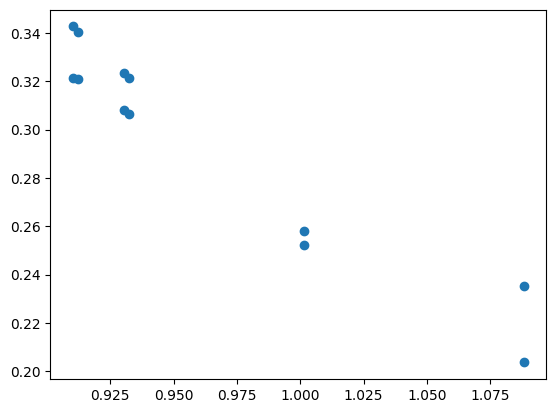

In [187]:
upper = 1.10
lower = 0.90

moneyness = np.array(moneyness)
IV_selection_calls = iv_call[np.where((moneyness <= upper) & (moneyness >= lower))]
IV_selection_puts = iv_put[np.where((moneyness >= lower) & (moneyness <= upper))]
moneyness_train_calls = moneyness[np.where((moneyness <= upper) & (moneyness >= lower))]
moneyness_train_puts = moneyness[np.where((moneyness >= lower) & (moneyness <= upper))]
volume_calls = call_volume[np.where((moneyness <= upper) & (moneyness >= lower))]
volume_puts = put_volume[np.where((moneyness >= lower) & (moneyness <= upper))]

moneyness_train = np.concatenate((moneyness_train_calls, moneyness_train_puts))
iv_train = np.concatenate((IV_selection_calls,IV_selection_puts))
volume_train = np.concatenate((volume_calls, volume_puts))

print(moneyness_train, "simple moneyness simple Log(S/K)")
print(iv_train, "IV sur calls et puts en fonction de la moneyness")
print(volume_train, "Volume")
plt.scatter(moneyness_train, iv_train, label = "Smile de marché")


The svi model class

In [188]:
class SVIModel:
    def __init__(self):
        self.params = None  # Parameters: a, b, rho, m, sigma

    @staticmethod
    def svi(log_moneyness, a, b, rho, m, sigma):
        """
        SVI formula: w(k) = a + b * (rho * (k - m) + sqrt((k - m)^2 + sigma^2))
        
        Parameters:
        - log_moneyness: log(K/S), array-like
        - a, b, rho, m, sigma: SVI parameters
        """
        term1 = rho * (log_moneyness - m)
        term2 = np.sqrt((log_moneyness - m)**2 + sigma**2)
        return a + b * (term1 + term2)

    def fit(self, train_data, volume_weights=None):
        """
        Fit SVI parameters to training data.
        
        Parameters:
        - train_data: DataFrame with columns ['log_moneyness', 'implied_volatility']
        - volume_weights: Optional array-like weights for each data point (e.g., volume)
        """
        log_moneyness = train_data['log_moneyness'].values
        implied_volatility = train_data['implied_volatility'].values

        if volume_weights is None:
            volume_weights = np.ones_like(implied_volatility)

        def objective(params):
            """Objective function for optimization"""
            a, b, rho, m, sigma = params
            if not (0 < b and -1 <= rho <= 1 and sigma > 0):
                return np.inf  # Penalize invalid parameter regions

            predicted_volatility = np.sqrt(self.svi(log_moneyness, a, b, rho, m, sigma))
            errors = (predicted_volatility - implied_volatility) ** 2
            weighted_errors = errors * volume_weights
            return np.sum(weighted_errors)

        # Improved initial guesses for parameters
        initial_guess = [0.05, 0.2, 0.0, 0.0, 0.1]
        bounds = [
            (1e-6, None),  # a > 0
            (1e-6, None),  # b > 0
            (-0.99, 0.99),  # -1 <= rho <= 1
            (-1.0, 1.0),    # m centered around 0 for log-moneyness
            (1e-6, None)    # sigma > 0
        ]

        # Minimize the objective function
        result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B', options={'maxiter': 100000})

        if result.success:
            self.params = result.x
        else:
            raise ValueError("SVI fit failed: " + result.message)

    def predict(self, log_moneyness):
        """
        Predict implied volatilities using the fitted SVI model.
        
        Parameters:
        - log_moneyness: log(K/S), array-like
        
        Returns:
        - Predicted implied volatilities
        """
        if self.params is None:
            raise ValueError("Model parameters are not fitted yet.")

        a, b, rho, m, sigma = self.params
        return np.sqrt(self.svi(log_moneyness, a, b, rho, m, sigma))

Fitted Parameters: [ 1.00000000e-06  5.22475831e-01 -7.87121769e-02  8.85970942e-02
  7.91732135e-02]
Predictions: [0.33856334 0.33621786 0.3338614  0.33149394 0.3291155  0.32672612
 0.32432582 0.32191466 0.31949273 0.3170601  0.31461691 0.31216328
 0.30969939 0.30722543 0.30474162 0.30224824 0.29974558 0.29723399
 0.29471386 0.29218563 0.28964981 0.28710697 0.28455773 0.2820028
 0.27944298 0.27687914 0.27431228 0.27174349 0.26917397 0.26660507
 0.26403826 0.2614752  0.25891767 0.25636767 0.25382738 0.2512992
 0.24878573 0.24628985 0.24381467 0.24136358 0.23894027 0.23654872
 0.23419322 0.23187837 0.2296091  0.22739068 0.22522866 0.22312891
 0.22109757 0.21914103 0.21726588 0.21547885 0.21378677 0.21219647
 0.21071468 0.20934796 0.20810259 0.20698444 0.20599887 0.20515062
 0.2044437  0.20388132 0.2034658  0.20319853 0.20307991 0.20310939
 0.20328545 0.20360566 0.20406674 0.20466466 0.20539468 0.20625154
 0.20722946 0.20832237 0.2095239  0.21082757 0.21222681 0.2137151
 0.21528601 0.216

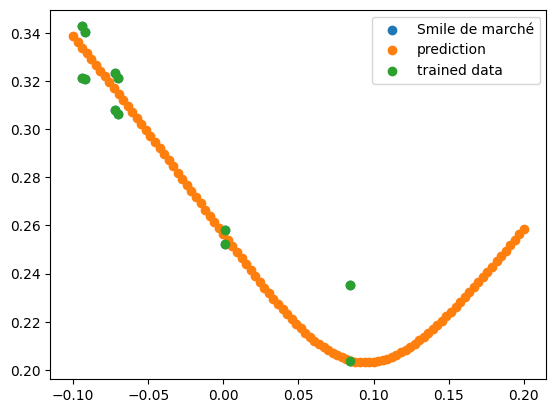

In [189]:
data = {
        'log_moneyness': np.log(moneyness_train),
        'implied_volatility': iv_train,
        'volume': volume_train
    }
train_data = pd.DataFrame(data)
# Volume weights
volume_weights = train_data['volume'].values / train_data['volume'].sum()
# Fit SVI model
svi_model = SVIModel()
plt.scatter(data["log_moneyness"], data["implied_volatility"], label = "Smile de marché")
svi_model.fit(train_data, volume_weights=volume_weights)

# Predict implied volatilities
log_moneyness_test = np.linspace(-0.10, 0.2, 100)
predictions = svi_model.predict(log_moneyness_test)
plt.scatter(log_moneyness_test, predictions, label = "prediction")
plt.scatter(np.log(moneyness_train), iv_train, label = "trained data")
plt.legend()
print("Fitted Parameters:", svi_model.params)
print("Predictions:", predictions)